In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sciStat
import sussix



---
# LHC tracking data
---

The following spectra (100 spectral lines each) are from LHC tracking data (No BB, but x-y coupling and strong 450 A arc octupoles). They accurately represent the (x-px),(y-py),(zeta-pzeta) tracjectories for 10k turns and are intended to be used as realistic example trajectories (validated manually).

In [2]:
# PARTICLES ON MOMENTUM
particles_on_p  = []
KAM_on_p  = []
for file in ['../tests/data/LHC_particle_on_momentum_1sigma.csv',
             '../tests/data/LHC_particle_on_momentum_3sigma.csv',
             '../tests/data/LHC_particle_on_momentum_5sigma.csv']:
    
    # Loading file
    df  = pd.read_csv(file,index_col=0)
    dct = {}
    for plane in ['x','y','zeta']:  

        _df = df[[f'A{plane}',f'Q{plane}']].rename(columns={f'A{plane}':'amplitude',f'Q{plane}':'frequency'}).astype({'amplitude':np.complex128,'frequency':np.float64})

        # Recreating the signal
        nturns = int(1e4)
        z,pz = sussix.generate_signal(_df.amplitude,_df.frequency,np.arange(int(nturns)))

        # Saving the signal
        dct[f'{plane}']   = z
        dct[f'p{plane}']  = pz
        dct[f'df{plane}'] = _df
    particles_on_p.append(dct)

    

# PARTICLES OFF MOMENTUM
particles_off_p  = []
KAM_off_p  = []
for file in ['../tests/data/LHC_particle_off_momentum_1sigma.csv',
             '../tests/data/LHC_particle_off_momentum_3sigma.csv',
             '../tests/data/LHC_particle_off_momentum_5sigma.csv']:
    
    # Loading file
    df  = pd.read_csv(file,index_col=0)
    dct = {}
    for plane in ['x','y','zeta']:  

        _df = df[[f'A{plane}',f'Q{plane}']].rename(columns={f'A{plane}':'amplitude',f'Q{plane}':'frequency'}).astype({'amplitude':np.complex128,'frequency':np.float64})

        # Recreating the signal
        nturns = int(1e4)
        z,pz = sussix.generate_signal(_df.amplitude,_df.frequency,np.arange(int(nturns)))

        # Saving the signal
        dct[f'{plane}']   = z
        dct[f'p{plane}']  = pz
        dct[f'df{plane}'] = _df
    particles_off_p.append(dct)





---
# Plotting the particles
---

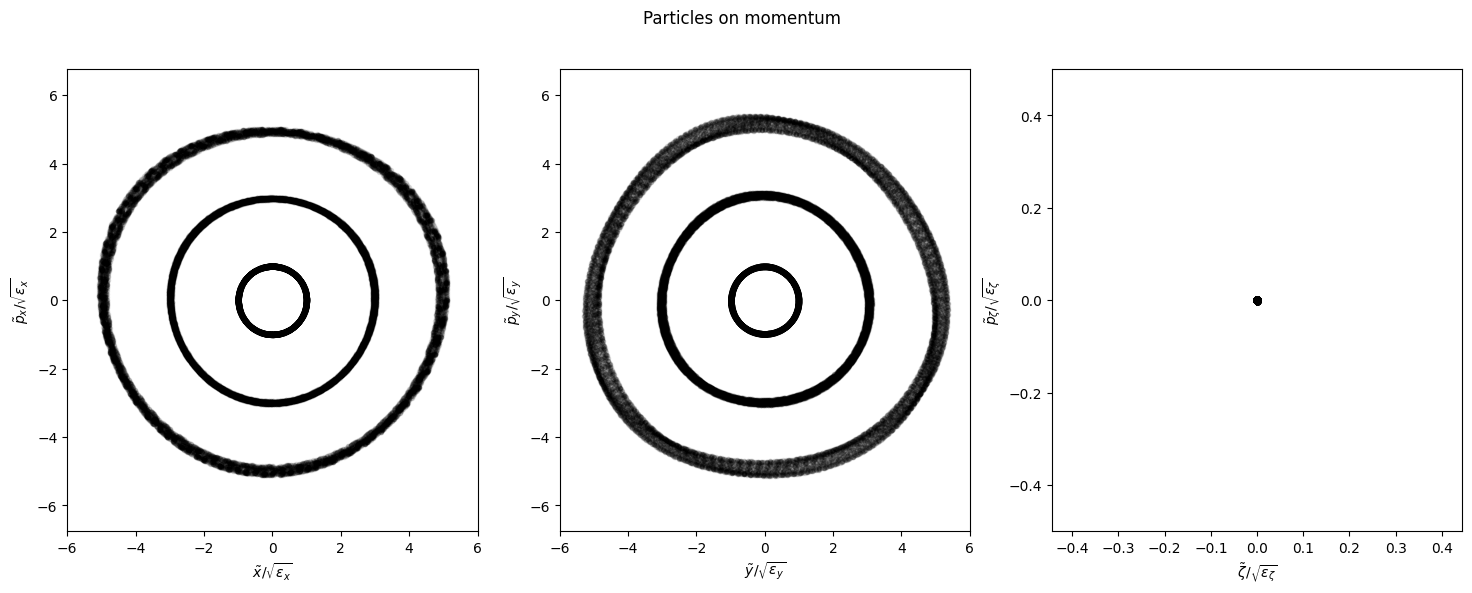

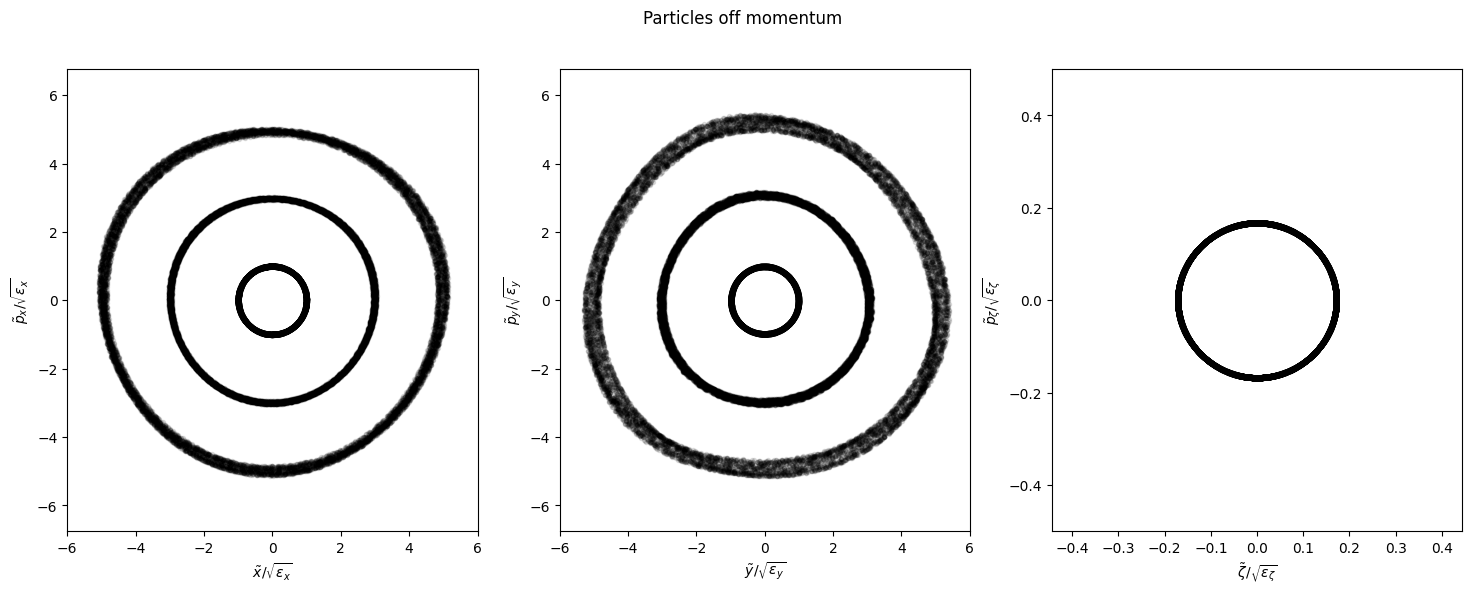

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Particles on momentum')
for part in particles_on_p:
    for plane,ax in zip(['x','y','zeta'],axes):
        plt.sca(ax)
        plt.plot(part[plane],part[f'p{plane}'],'.',color='k',alpha=0.1)

# Adding labels
for plane,ax in zip(['x','y','zeta'],axes):
    plt.sca(ax)
    plt.axis('equal')
    if plane == 'zeta':
        plane = '\zeta'
    plt.xlabel(rf'$\tilde {plane}/\sqrt{{\varepsilon_{plane}}}$')
    plt.ylabel(rf'$\tilde p_{plane}/\sqrt{{\varepsilon_{plane}}}$')
    
    if plane == '\zeta':
        plt.xlim(-0.5,0.5)
        plt.ylim(-0.5,0.5)
    else:
        plt.xlim(-6,6)
        plt.ylim(-6,6)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Particles off momentum')
for part in particles_off_p:
    for plane,ax in zip(['x','y','zeta'],axes):
        plt.sca(ax)
        plt.plot(part[plane],part[f'p{plane}'],'.',color='k',alpha=0.1)

# Adding labels
for plane,ax in zip(['x','y','zeta'],axes):
    plt.sca(ax)
    plt.axis('equal')
    if plane == 'zeta':
        plane = '\zeta'
    plt.xlabel(rf'$\tilde {plane}/\sqrt{{\varepsilon_{plane}}}$')
    plt.ylabel(rf'$\tilde p_{plane}/\sqrt{{\varepsilon_{plane}}}$')
    
    if plane == '\zeta':
        plt.xlim(-0.5,0.5)
        plt.ylim(-0.5,0.5)
    else:
        plt.xlim(-6,6)
        plt.ylim(-6,6)


---
# Extracting the tune
---

In [4]:
for part,sigma in zip(particles_on_p,[1,3,5]):
    print(40*'-')
    print(f'Particle @ {sigma} sigma:')
    print(f'x only        : {sussix.tune(part["x"],window_order=2)}')
    print(f'x-px          : {sussix.tune(part["x"],part["px"],window_order=2)}')

----------------------------------------
Particle @ 1 sigma:
x only        : 0.31002084339097
x-px          : 0.3100208433909691
----------------------------------------
Particle @ 3 sigma:
x only        : 0.31017724865960494
x-px          : 0.31017724865960405
----------------------------------------
Particle @ 5 sigma:
x only        : 0.31048671666610894
x-px          : 0.3104867166661067


---
# Full phase space analysis, x-plane
---

(-6.0, 6.0)

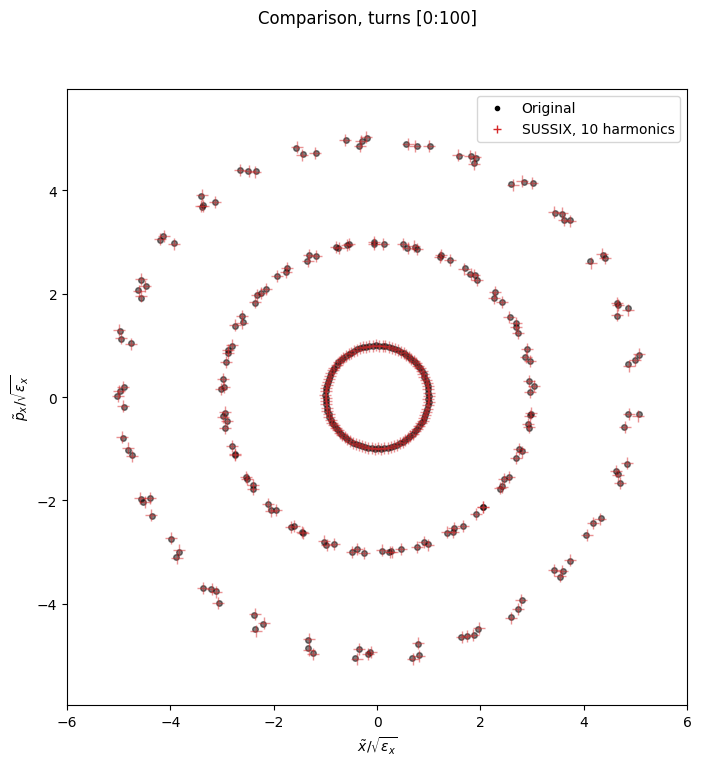

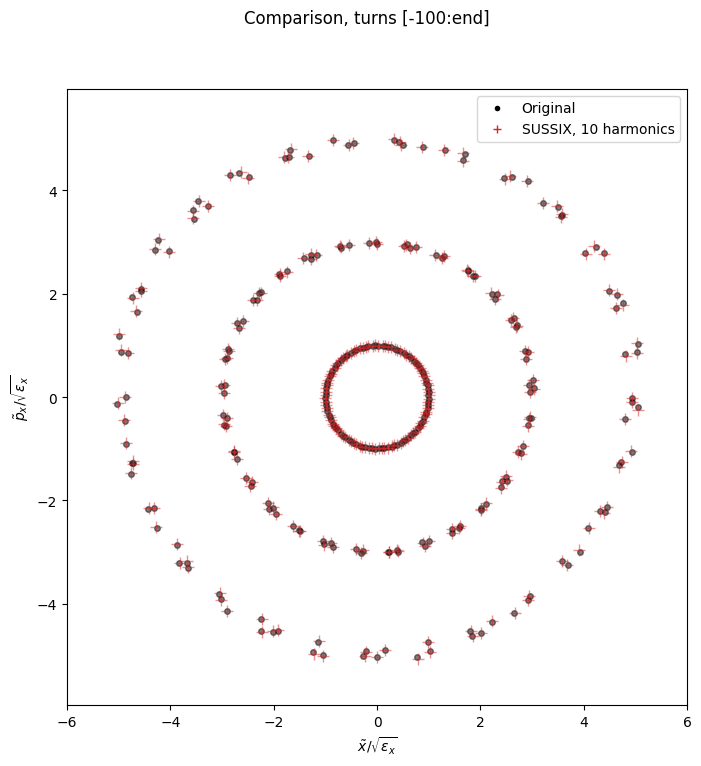

In [5]:
#-----------------------------
# PARAMETERS
n_harm = 10
nturns = 100
#-----------------------------

particles = particles_on_p

plt.figure(figsize=(8,8))
plt.suptitle(f'Comparison, turns [0:{nturns}]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],part['px'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r,px_r = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(part['x'][:nturns],part['px'][:nturns] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(x_r[:nturns],px_r[:nturns]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.axis('equal')
plt.xlabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')
plt.ylabel(rf'$\tilde p_x/\sqrt{{\varepsilon_x}}$')
plt.xlim(-6,6)
plt.ylim(-6,6)


plt.figure(figsize=(8,8))
plt.suptitle(f'Comparison, turns [-{nturns}:end]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],part['px'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r,px_r = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(part['x'][-nturns:],part['px'][-nturns:] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(x_r[-nturns:],px_r[-nturns:]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.axis('equal')
plt.xlabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')
plt.ylabel(rf'$\tilde p_x/\sqrt{{\varepsilon_x}}$')
plt.xlim(-6,6)
plt.ylim(-6,6)



---
# Position ONLY analysis
---


Text(0, 0.5, '$\\tilde x/\\sqrt{\\varepsilon_x}$')

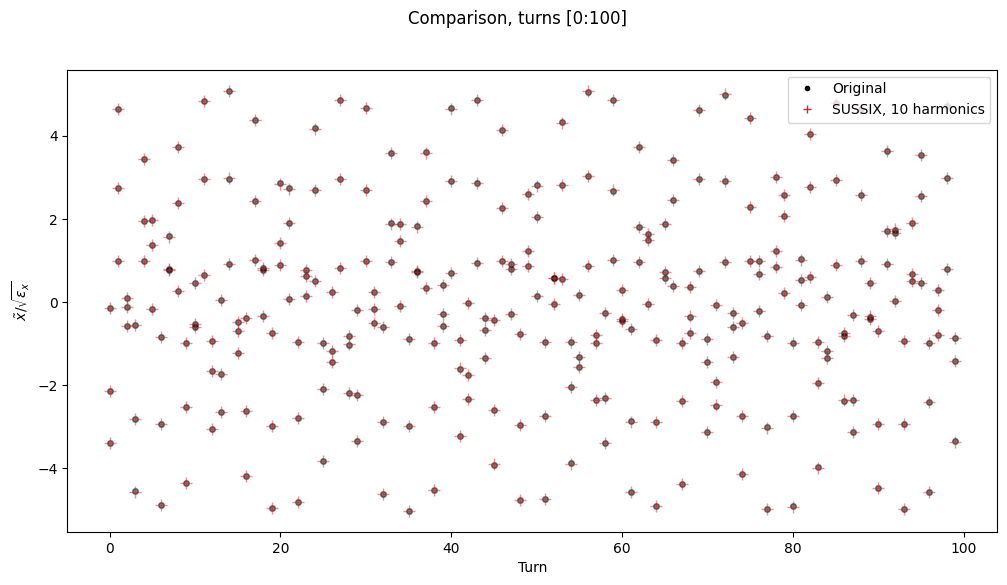

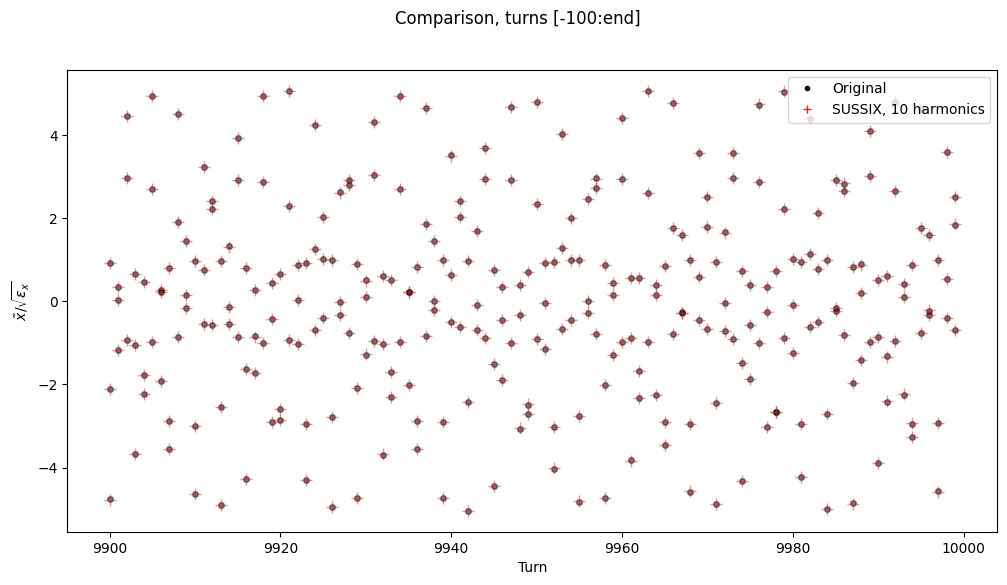

In [6]:
particles = particles_on_p

plt.figure(figsize=(12,6))
plt.suptitle(f'Comparison, turns [0:{nturns}]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r, _   = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(np.arange(0,nturns),part['x'][:nturns] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(np.arange(0,nturns),x_r[:nturns]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.xlabel(rf'Turn')
plt.ylabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')


plt.figure(figsize=(12,6))
plt.suptitle(f'Comparison, turns [-{nturns}:end]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r, _   = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(np.arange(int(1e4-nturns),int(1e4)),part['x'][-nturns:] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(np.arange(int(1e4-nturns),int(1e4)),x_r[-nturns:]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.xlabel(rf'Turn')
plt.ylabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')


---
# Spectrum comparison
---

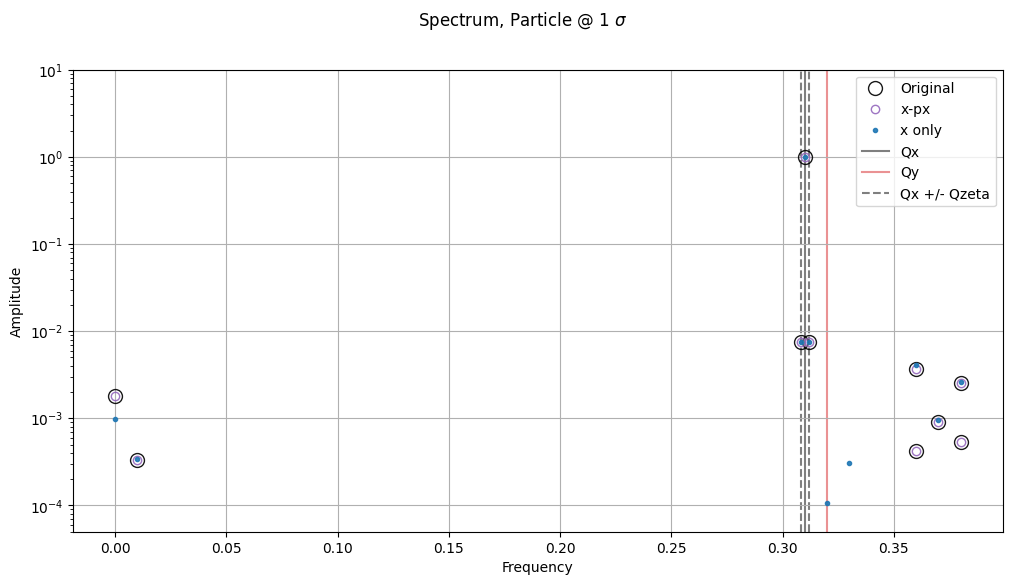

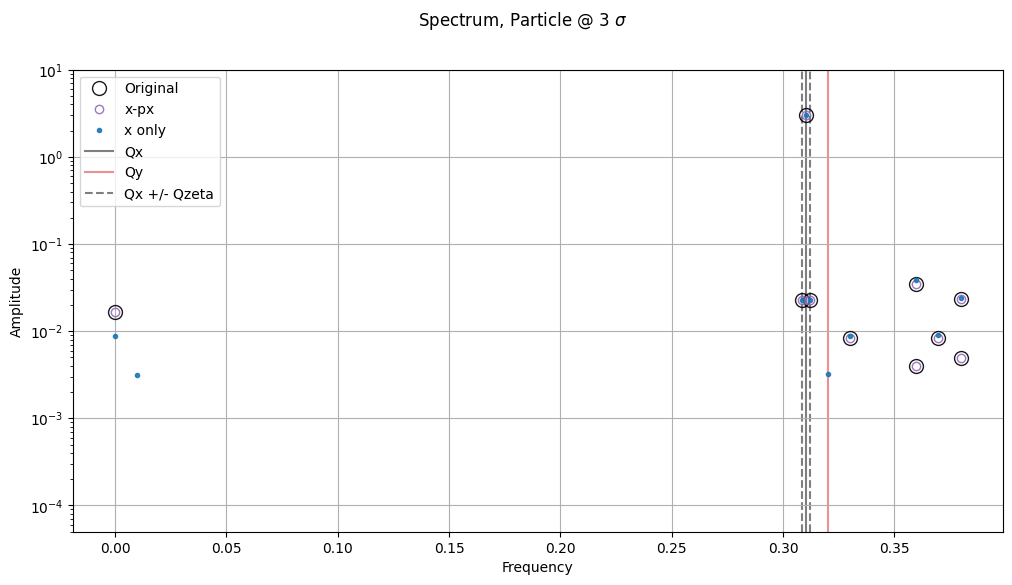

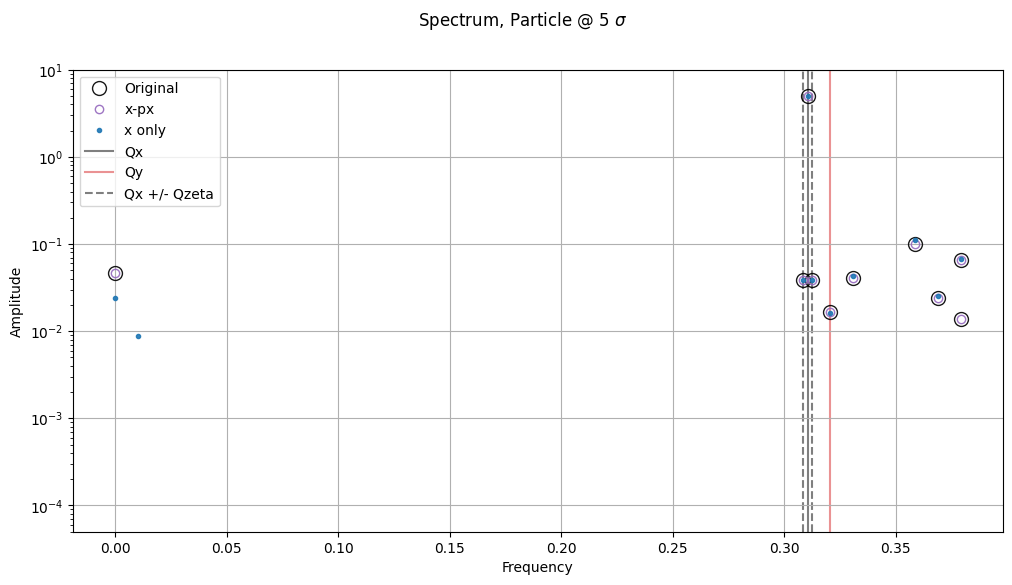

In [7]:
particles = particles_on_p
for part,sigma in zip(particles,[1,3,5]):
    plt.figure(figsize=(12,6))
    plt.suptitle(f'Spectrum, Particle @ {sigma} $\sigma$')
    spectrum_x    = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    spectrum_x_px = sussix.harmonics(part['x'],part['px'],  num_harmonics = n_harm,window_order=2,to_pandas=True)

    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

    plt.plot( np.abs(part['dfx'].frequency[:n_harm]),np.abs(part['dfx'].amplitude[:n_harm]),'o',ms=10,mfc='none',   color='black' ,alpha=0.9,label='Original')
    plt.plot( np.abs(spectrum_x_px.frequency),np.abs(spectrum_x_px.amplitude),'o',mfc='none',   color='C4' ,alpha=0.9,label='x-px')
    plt.plot( np.abs(spectrum_x.frequency)   ,np.abs(spectrum_x.amplitude),'.'   ,                    color='C0' ,alpha=0.9,label='x only')

    plt.axvline(fundamental_tunes[0],color='k',label='Qx',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[1],color='C3',label='Qy',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]+fundamental_tunes[2],ls='--',color='k',label='Qx +/- Qzeta',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]-fundamental_tunes[2],ls='--',color='k',zorder = -100,alpha=0.5)

    plt.legend()
    plt.yscale('log')
    plt.ylim(5e-5,1e1)
    plt.grid()
    plt.xlabel(rf'Frequency')
    plt.ylabel(rf'Amplitude')
    

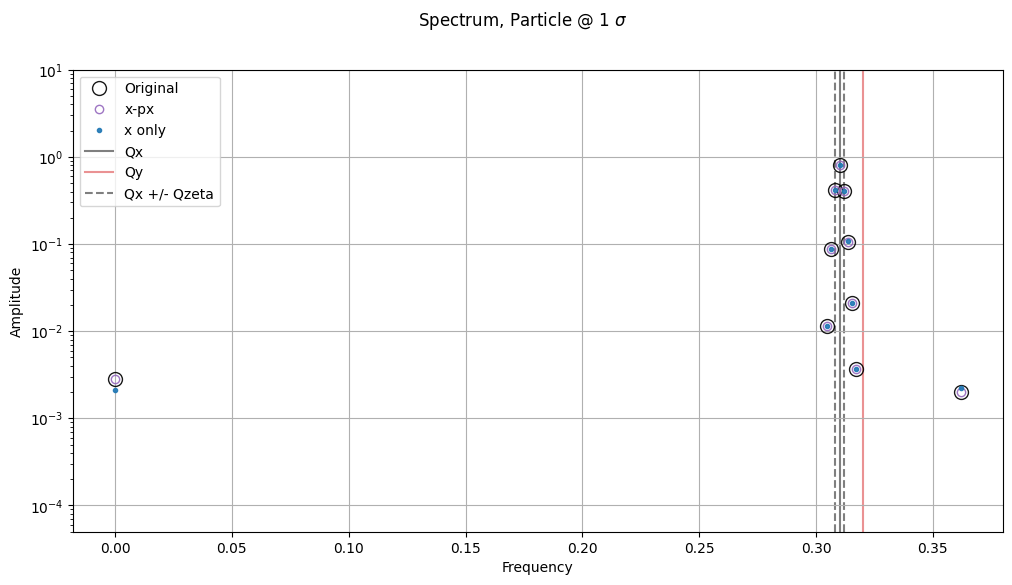

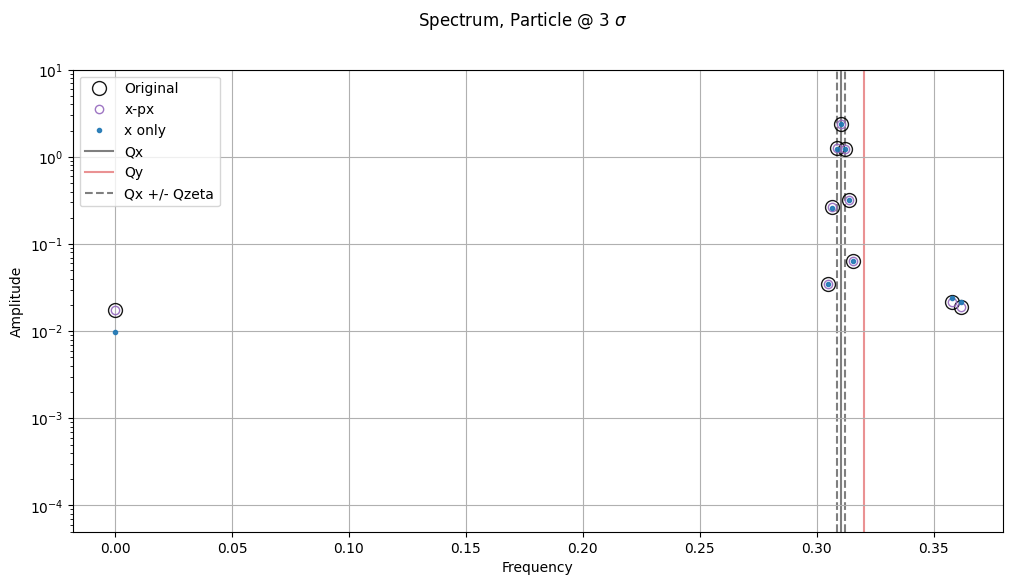

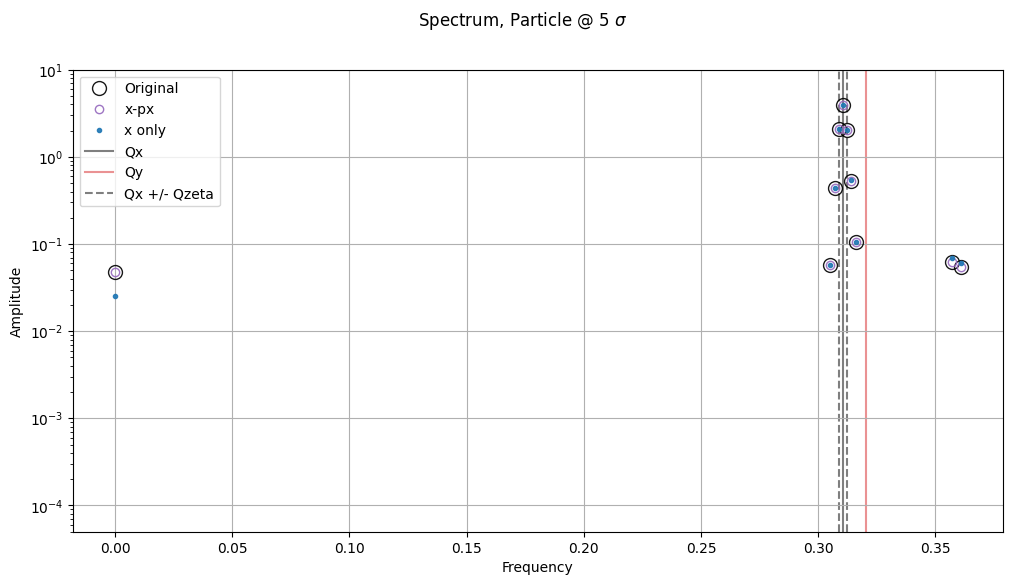

In [8]:
particles = particles_off_p
for part,sigma in zip(particles,[1,3,5]):
    plt.figure(figsize=(12,6))
    plt.suptitle(f'Spectrum, Particle @ {sigma} $\sigma$')
    spectrum_x    = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    spectrum_x_px = sussix.harmonics(part['x'],part['px'],  num_harmonics = n_harm,window_order=2,to_pandas=True)

    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

    plt.plot( np.abs(part['dfx'].frequency[:n_harm]),np.abs(part['dfx'].amplitude[:n_harm]),'o',ms=10,mfc='none',   color='black' ,alpha=0.9,label='Original')
    plt.plot( np.abs(spectrum_x_px.frequency),np.abs(spectrum_x_px.amplitude),'o',mfc='none',   color='C4' ,alpha=0.9,label='x-px')
    plt.plot( np.abs(spectrum_x.frequency)   ,np.abs(spectrum_x.amplitude),'.'   ,                    color='C0' ,alpha=0.9,label='x only')

    plt.axvline(fundamental_tunes[0],color='k',label='Qx',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[1],color='C3',label='Qy',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]+fundamental_tunes[2],ls='--',color='k',label='Qx +/- Qzeta',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]-fundamental_tunes[2],ls='--',color='k',zorder = -100,alpha=0.5)

    plt.legend()
    plt.yscale('log')
    plt.ylim(5e-5,1e1)
    plt.grid()
    plt.xlabel(rf'Frequency')
    plt.ylabel(rf'Amplitude')
    

---
# Frequencies as linear combinations?
---

In [9]:
particles = particles_on_p

for part in particles:
    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]
    spectrum_x        = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    combination_jklm  = sussix.find_linear_combinations(spectrum_x.frequency,fundamental_tunes = fundamental_tunes,max_harmonic_order = 10,to_pandas=True)
    display(combination_jklm)

,resonance,err,freq
0,"(1, 0, 0, 0)",9.436896e-16,3.100208e-01
1,"(1, 0, 1, 0)",4.788447e-12,3.118874e-01
2,"(1, 0, -1, 0)",1.497746e-12,3.081543e-01
3,"(0, -2, 0, 1)",7.494005e-14,3.599591e-01
4,"(-2, 0, 0, 1)",9.414691e-14,3.799583e-01
5,"(0, 0, 0, 0)",1.996704e-17,1.996704e-17
6,"(-1, -1, 0, 1)",9.559020e-14,3.699587e-01
7,"(-1, 1, 0, 0)",1.220378e-14,9.999620e-03
8,"(-1, 2, 0, 0)",3.843981e-12,3.300201e-01
9,"(0, 1, 0, 0)",1.812478e-11,3.200205e-01


,resonance,err,freq
0,"(1, 0, 0, 0)",8.881784e-16,3.101772e-01
1,"(0, -2, 0, 1)",7.321921e-14,3.595955e-01
2,"(-2, 0, 0, 1)",9.436896e-14,3.796455e-01
3,"(1, 0, 1, 0)",4.436063e-12,3.120438e-01
4,"(1, 0, -1, 0)",1.939782e-12,3.083107e-01
5,"(0, 0, 0, 0)",2.498748e-20,-2.498748e-20
6,"(-1, -1, 0, 1)",6.533662e-14,3.696205e-01
7,"(-1, 2, 0, 0)",1.026734e-12,3.302273e-01
8,"(0, 1, 0, 0)",2.034317e-12,3.202023e-01
9,"(-1, 1, 0, 0)",2.225650e-15,1.002501e-02


,resonance,err,freq
0,"(1, 0, 0, 0)",2.220446e-15,3.104867e-01
1,"(0, -2, 0, 1)",1.451061e-12,3.588444e-01
2,"(-2, 0, 0, 1)",1.595463e-11,3.790266e-01
3,"(0, 0, 0, 0)",5.500859e-18,-5.500859e-18
4,"(-1, 2, 0, 0)",8.751444e-11,3.306688e-01
5,"(1, 0, 1, 0)",6.944187e-09,3.123532e-01
6,"(1, 0, -1, 0)",3.491631e-09,3.086202e-01
7,"(-1, -1, 0, 1)",1.324774e-11,3.689355e-01
8,"(0, 1, 0, 0)",3.100631e-11,3.205778e-01
9,"(-1, 1, 0, 0)",8.022038e-13,1.009106e-02


In [10]:
particles = particles_off_p

for part in particles:
    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]
    spectrum_x        = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    combination_jklm  = sussix.find_linear_combinations(spectrum_x.frequency,fundamental_tunes = fundamental_tunes,max_harmonic_order = 10,to_pandas=True)
    display(combination_jklm)

,resonance,err,freq
0,"(1, 0, 0, 0)",2.033929e-13,3.101051e-01
1,"(1, 0, 1, 0)",5.032696e-12,3.119052e-01
2,"(1, 0, -1, 0)",1.388129e-11,3.083051e-01
3,"(1, 0, 2, 0)",2.177547e-11,3.137052e-01
4,"(1, 0, -2, 0)",1.464479e-11,3.065050e-01
5,"(1, 0, 3, 0)",1.353971e-10,3.155053e-01
6,"(1, 0, -3, 0)",1.856115e-11,3.047049e-01
7,"(0, 0, 0, 0)",1.138730e-17,-1.138730e-17
8,"(1, 0, 4, 0)",2.367635e-09,3.173054e-01
9,"(0, -2, 1, 1)",2.759081e-10,3.618182e-01


,resonance,err,freq
0,"(1, 0, 0, 0)",2.039480e-13,3.102616e-01
1,"(1, 0, -1, 0)",2.996864e-11,3.084616e-01
2,"(1, 0, 1, 0)",1.251432e-11,3.120617e-01
3,"(1, 0, 2, 0)",3.256595e-11,3.138617e-01
4,"(1, 0, -2, 0)",1.451372e-11,3.066615e-01
5,"(1, 0, 3, 0)",3.073184e-10,3.156618e-01
6,"(1, 0, -3, 0)",1.278683e-11,3.048614e-01
7,"(0, -2, 1, 1)",2.819267e-11,3.614535e-01
8,"(0, -2, -1, 1)",2.389755e-11,3.578534e-01
9,"(0, 0, 0, 0)",3.099521e-19,-3.099521e-19


,resonance,err,freq
0,"(1, 0, 0, 0)",1.751377e-13,3.105712e-01
1,"(1, 0, 1, 0)",4.033002e-11,3.123712e-01
2,"(1, 0, -1, 0)",6.385448e-13,3.087711e-01
3,"(1, 0, 2, 0)",3.409734e-11,3.141712e-01
4,"(1, 0, -2, 0)",1.885535e-10,3.069711e-01
5,"(1, 0, 3, 0)",1.012895e-09,3.159713e-01
6,"(0, -2, -1, 1)",1.410213e-10,3.570992e-01
7,"(0, -2, 1, 1)",5.265099e-10,3.606992e-01
8,"(1, 0, -3, 0)",1.049589e-10,3.051711e-01
9,"(0, 0, 0, 0)",2.238375e-17,2.238375e-17


---
# Convergence
---

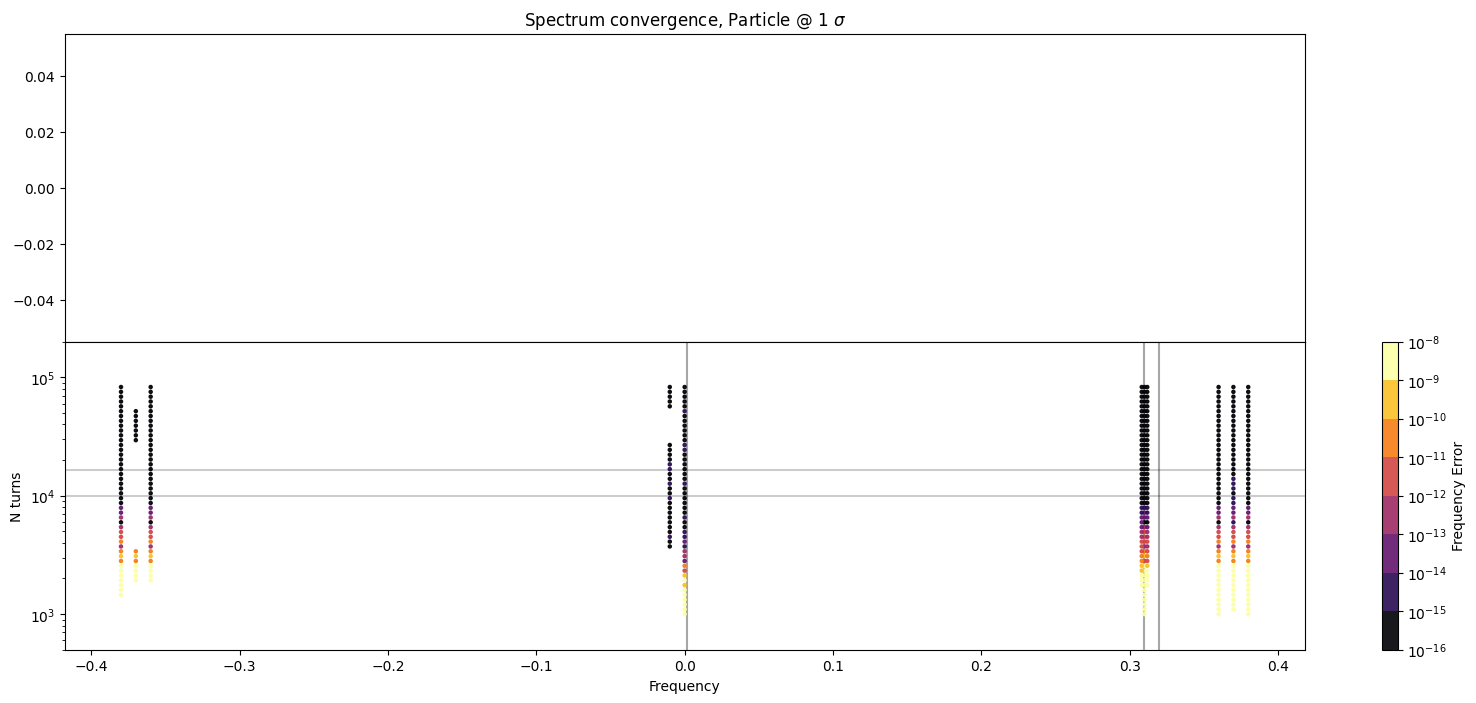

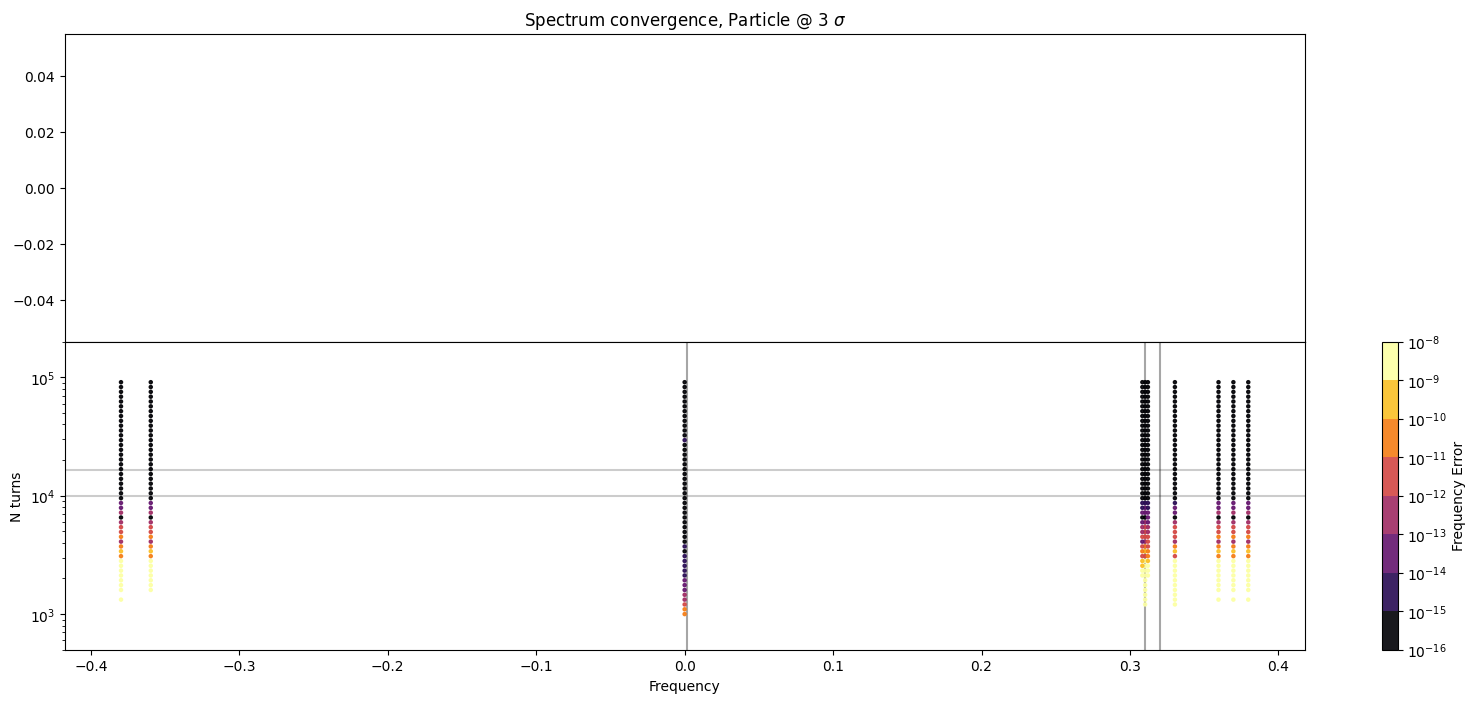

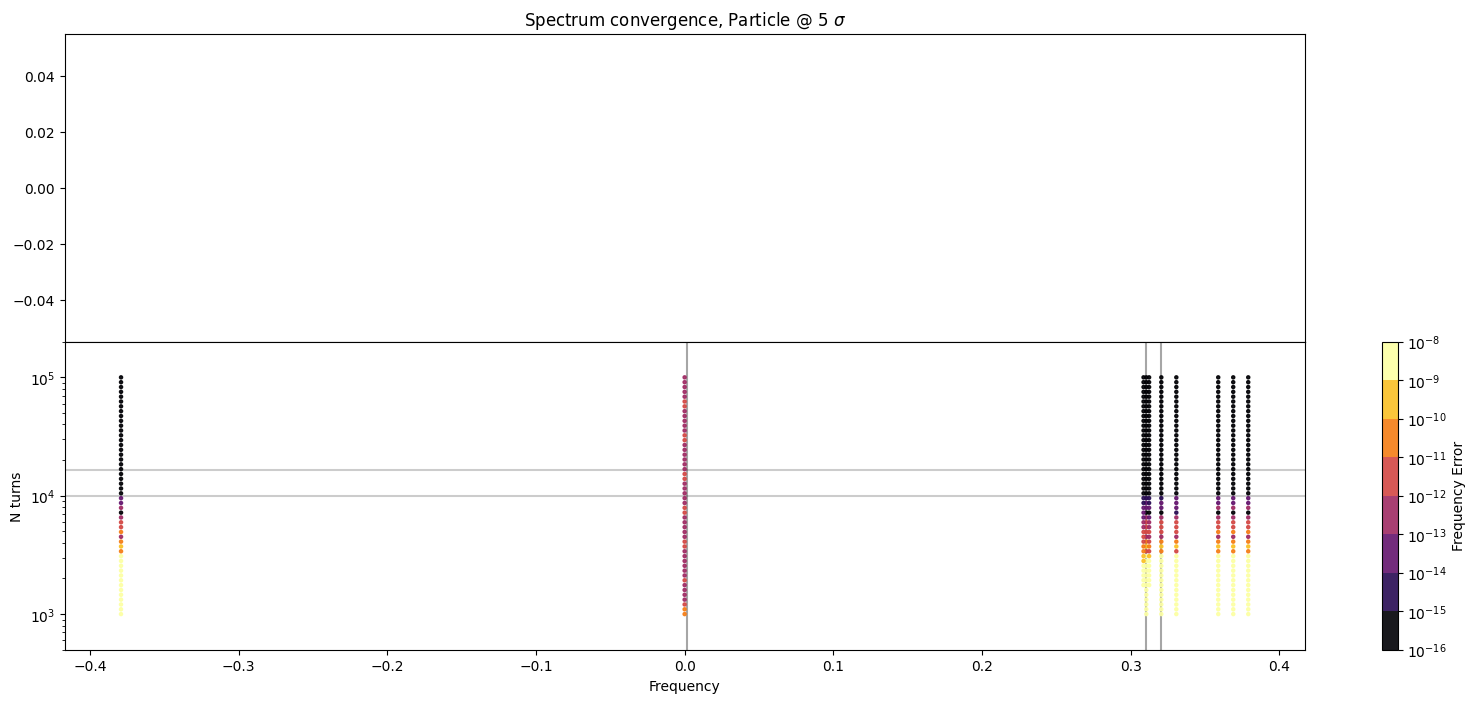

In [11]:

import matplotlib.colors as colors

n_harm = 10
cmap_name = 'inferno'

# Since the signal is artificially generated from a sum of phasors, let's look beyond the nturn = 1e4 limit and see if we can find the expected frequencies.
plane     = 'x'
particles = particles_on_p

for part,sigma in zip(particles,[1,3,5]):

    x,px = sussix.generate_signal(part[f'df{plane}'].amplitude,part[f'df{plane}'].frequency,np.arange(int(1e5)))
    expected = part[f'df{plane}'][:2*n_harm]
    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

    # Trying to identify line based on jklm
    #---------------------------------------
    combination_jklm  = sussix.find_linear_combinations(expected.frequency,fundamental_tunes = fundamental_tunes,max_harmonic_order = 10,to_pandas=True)
    if not len(combination_jklm.resonance.unique()) == 2*n_harm:
        continue

    # setting jklm as index
    if 'jklm' not in expected.columns:
        expected.insert(0,'jklm',combination_jklm.resonance)
    expected.set_index('jklm',inplace=True)
    #---------------------------------------

    N_vec = np.logspace(3,5,50).astype(int)

    results = []
    for N in N_vec:
        spectrum = sussix.harmonics(x[:N], px[:N], num_harmonics = n_harm,window_order=4,to_pandas=True)
        if len(spectrum) != len(spectrum.dropna()):
            raise ValueError('NaN found')
        # Trying to identify line based on jklm
        #---------------------------------------
        combination_jklm  = sussix.find_linear_combinations(spectrum.frequency,fundamental_tunes = fundamental_tunes,max_harmonic_order = 10,to_pandas=True)
        if not len(combination_jklm.resonance.unique()) == n_harm:
            continue

        # setting jklm as index
        spectrum.insert(0,'jklm',combination_jklm.resonance)
        spectrum.set_index('jklm',inplace=True)
        #---------------------------------------

        # Computing error
        #---------------------------------------
        spectrum.insert(1,'Err:A',np.abs(spectrum.amplitude.abs() - expected.amplitude.abs()))
        spectrum.insert(2,'Err:Q',np.abs(spectrum.frequency - expected.frequency))
        spectrum.loc[spectrum['Err:Q']==0,'Err:Q'] = 1e-21
        #---------------------------------------

        results.append(spectrum)


    # PLOTTING
    fig, axs = plt.subplots(2, 1,figsize=(20,8))
    plt.subplots_adjust(hspace=0)
    axs[0].set_title(f'Spectrum convergence, Particle @ {sigma} $\sigma$')

    # Bottom plot
    #-----------------------------
    plt.sca(axs[1])
    bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    

    for N,spectrum in zip(N_vec,results):
        plt.scatter(spectrum.frequency,N*np.ones(len(spectrum)),c=spectrum['Err:Q'],s=5,alpha=0.9,norm=norm,cmap=cmap_name )
        # if len(spectrum) != len(spectrum.dropna()):
            # display(spectrum)

    cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
    cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 

    plt.axvline(fundamental_tunes[0],color='grey',alpha=0.7,zorder=-10)
    plt.axvline(fundamental_tunes[1],color='grey',alpha=0.7,zorder=-10)
    plt.axvline(fundamental_tunes[2],color='grey',alpha=0.7,zorder=-10)
    plt.axhline(1e4,color='k',alpha=0.2,zorder=-10)
    plt.axhline(2**14,color='k',alpha=0.2,zorder=-10)
    plt.yscale('log')
    plt.ylim(np.min(N_vec)/2,np.max(N_vec)*2)
    plt.xlabel('Frequency')
    plt.ylabel('N turns')
    #-----------------------------

    # plt.xlim([-0.1,0.1])


    plt.sca(axs[0])
    # plt.plot(expected.frequency,np.abs(expected.amplitude),'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
    # plt.plot(results.frequency,np.abs(results.amplitude),'.',color='k',alpha=0.8,ms=3,label='SUSSIX')
    plt.scatter(np.nan,np.nan)
    cbar = plt.colorbar()
    cbar.ax.set_visible(False)
    plt.xticks([])



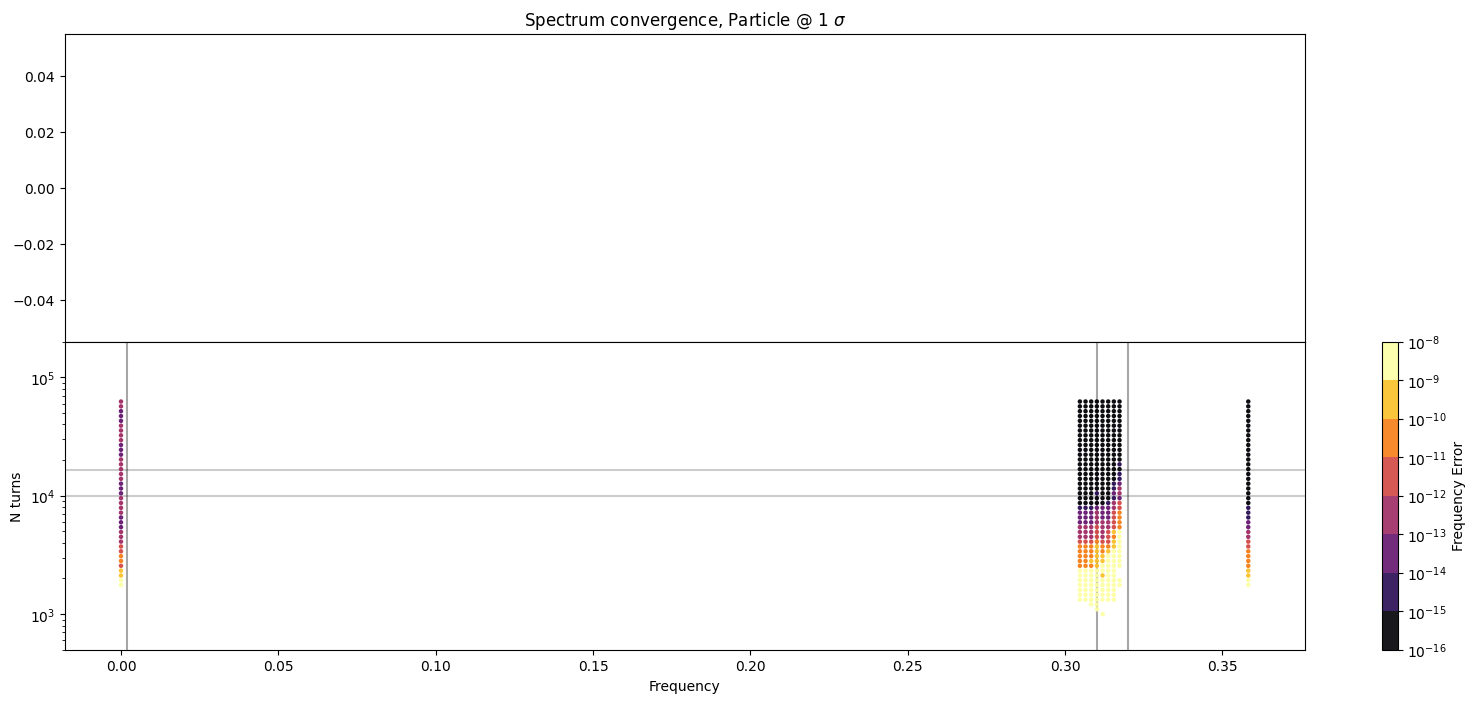

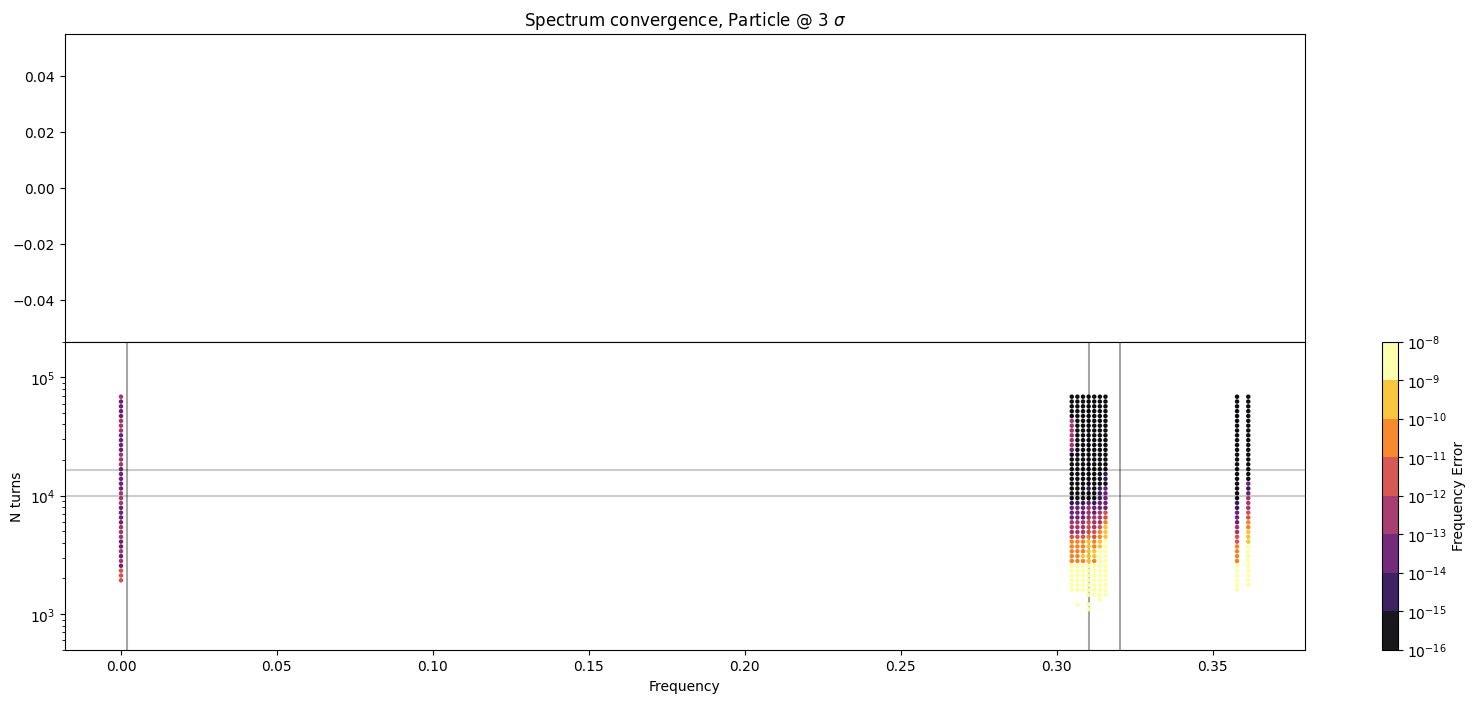

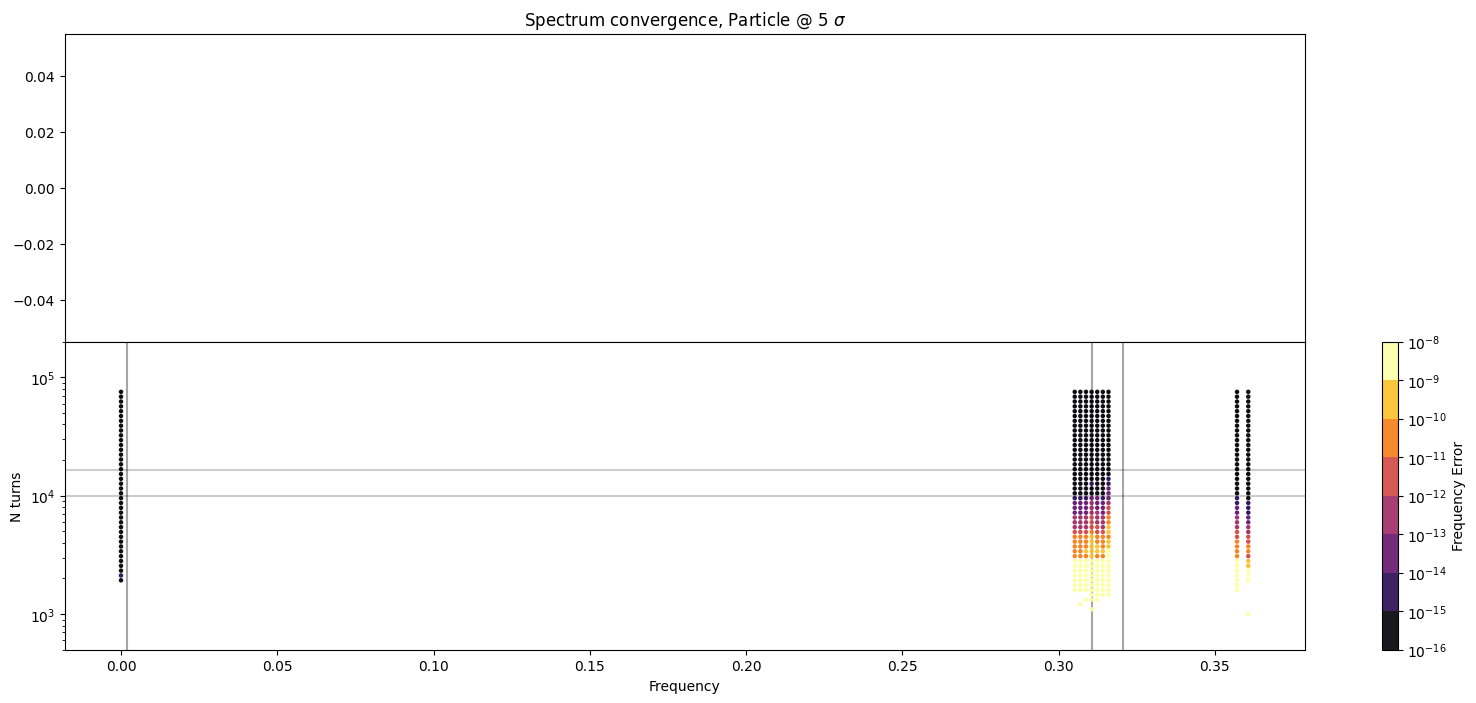

In [12]:

import matplotlib.colors as colors

n_harm = 10
cmap_name = 'inferno'

# Since the signal is artificially generated from a sum of phasors, let's look beyond the nturn = 1e4 limit and see if we can find the expected frequencies.
plane     = 'x'
particles = particles_off_p

for part,sigma in zip(particles,[1,3,5]):

    x,px = sussix.generate_signal(part[f'df{plane}'].amplitude,part[f'df{plane}'].frequency,np.arange(int(1e5)))
    expected = part[f'df{plane}'][:2*n_harm]
    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

    # Trying to identify line based on jklm
    #---------------------------------------
    combination_jklm  = sussix.find_linear_combinations(expected.frequency,fundamental_tunes = fundamental_tunes,max_harmonic_order = 10,to_pandas=True)
    if not len(combination_jklm.resonance.unique()) == 2*n_harm:
        continue

    # setting jklm as index
    if 'jklm' not in expected.columns:
        expected.insert(0,'jklm',combination_jklm.resonance)
    expected.set_index('jklm',inplace=True)
    #---------------------------------------

    N_vec = np.logspace(3,5,50).astype(int)

    results = []
    for N in N_vec:
        spectrum = sussix.harmonics(x[:N], px[:N], num_harmonics = n_harm,window_order=4,to_pandas=True)
        if len(spectrum) != len(spectrum.dropna()):
            raise ValueError('NaN found')
        # Trying to identify line based on jklm
        #---------------------------------------
        combination_jklm  = sussix.find_linear_combinations(spectrum.frequency,fundamental_tunes = fundamental_tunes,max_harmonic_order = 10,to_pandas=True)
        if not len(combination_jklm.resonance.unique()) == n_harm:
            continue

        # setting jklm as index
        spectrum.insert(0,'jklm',combination_jklm.resonance)
        spectrum.set_index('jklm',inplace=True)
        #---------------------------------------

        # Computing error
        #---------------------------------------
        spectrum.insert(1,'Err:A',np.abs(spectrum.amplitude.abs() - expected.amplitude.abs()))
        spectrum.insert(2,'Err:Q',np.abs(spectrum.frequency - expected.frequency))
        spectrum.loc[spectrum['Err:Q']==0,'Err:Q'] = 1e-21
        #---------------------------------------

        results.append(spectrum)


    # PLOTTING
    fig, axs = plt.subplots(2, 1,figsize=(20,8))
    plt.subplots_adjust(hspace=0)
    axs[0].set_title(f'Spectrum convergence, Particle @ {sigma} $\sigma$')

    # Bottom plot
    #-----------------------------
    plt.sca(axs[1])
    bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    

    for N,spectrum in zip(N_vec,results):
        plt.scatter(spectrum.frequency,N*np.ones(len(spectrum)),c=spectrum['Err:Q'],s=5,alpha=0.9,norm=norm,cmap=cmap_name )
        # if len(spectrum) != len(spectrum.dropna()):
            # display(spectrum)

    cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
    cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 

    plt.axvline(fundamental_tunes[0],color='grey',alpha=0.7,zorder=-10)
    plt.axvline(fundamental_tunes[1],color='grey',alpha=0.7,zorder=-10)
    plt.axvline(fundamental_tunes[2],color='grey',alpha=0.7,zorder=-10)
    plt.axhline(1e4,color='k',alpha=0.2,zorder=-10)
    plt.axhline(2**14,color='k',alpha=0.2,zorder=-10)
    plt.yscale('log')
    plt.ylim(np.min(N_vec)/2,np.max(N_vec)*2)
    plt.xlabel('Frequency')
    plt.ylabel('N turns')
    #-----------------------------

    # plt.xlim([-0.1,0.1])


    plt.sca(axs[0])
    # plt.plot(expected.frequency,np.abs(expected.amplitude),'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
    # plt.plot(results.frequency,np.abs(results.amplitude),'.',color='k',alpha=0.8,ms=3,label='SUSSIX')
    plt.scatter(np.nan,np.nan)
    cbar = plt.colorbar()
    cbar.ax.set_visible(False)
    plt.xticks([])

